This notebook is for intial analysis of the NSNS optimized runs of COMPAS

In [1]:
#imports!

# let's import things
import h5py as h5 
import pandas as pd
from astropy.table import Table
from astropy import units as u
from astropy import constants as const
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text.latex', preamble=r'\usepackage{textgreek}')
plt.rc('font', family='serif')
import sys
import os
from scipy import stats
import seaborn as sns
import matplotlib as mpl

# Add the subdir to sys.path for our created scripts
sys.path.append('/home/jovyan/home/research_work/useful_py_scripts/')
sys.path.append('/home/jovyan/home/research_work/making_figures/paper_figures/')

# Now you can import the module
import useful_fncs
import figure_utils
import utils_from_others

# import for axes labels 
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif"
})

In [2]:
# let's first look at the NSNS_output

# the average_SF_mass_needed is Average_SF_mass_needed =  10892909.034667056

pathToH5_NSNS = '/home/jovyan/home/copied_files/N1e6_NSNS_Fid/COMPAS_Output_wWeights.h5'

Data_NSNS  = h5.File(pathToH5_NSNS, "r")

DCOs_NSNS = Data_NSNS['BSE_Double_Compact_Objects'] # getting the DCO objects

# gathering the double compact objects that we have computed rates for
DCO_mask_NSNS = Data_NSNS['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['DCOmask'][()]

# making sure we are rpesenting the true universe
mixture_weights_all = DCOs_NSNS['mixture_weight'][()]
mixture_weights = mixture_weights_all[DCO_mask_NSNS]

# times (these should be in Myr)
lifetimes_all = DCOs_NSNS['Time'][()]
lifetimes = lifetimes_all[DCO_mask_NSNS]

col_times_all = DCOs_NSNS['Coalescence_Time'][()]
col_times = col_times_all[DCO_mask_NSNS]

# this should hypothetically be the DCO systems that merge within a hubble time (since DCO mask was applied) 
delay_times = lifetimes + col_times

In [3]:
# let's plot the rate of the systems that merge within a hubble time

hubble_time = 13.9e3
condition_mergers = delay_times < hubble_time
mergers = np.sum(condition_mergers)

# mixture_weights_merged = mixture_weights[condition_mergers]

rates_DCO = Data_NSNS['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['merger_rate'][()]
rates_DCO_masked = rates_DCO[condition_mergers]

redshifts = Data_NSNS['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['redshifts'][()]


# selecting for NSNS
stellar_types_all_1 = DCOs_NSNS['Stellar_Type(1)'][()]
stellar_types_1 = stellar_types_all_1[DCO_mask_NSNS]
stellar_types_1_merged = stellar_types_1[condition_mergers]

stellar_types_all_2 = DCOs_NSNS['Stellar_Type(2)'][()]
stellar_types_2 = stellar_types_all_2[DCO_mask_NSNS]
stellar_types_2_merged = stellar_types_2[condition_mergers]

NSNS_systems_bool = np.logical_and(stellar_types_1_merged==13, stellar_types_2_merged==13)
NSNS_rate = np.sum(rates_DCO_masked[NSNS_systems_bool], axis=0)

In [4]:
# let's now do this for the WDWD systems 

HeWD_bool,COWD_bool,ONeWD_bool,HeCOWD_bool,HeONeWD_bool,COHeWD_bool,COONeWD_bool,ONeHeWD_bool,ONeCOWD_bool = useful_fncs.WD_BINARY_BOOLS(stellar_types_1_merged, stellar_types_2_merged)
carbon_oxygen_bool = np.logical_or(ONeCOWD_bool,np.logical_or(COONeWD_bool,np.logical_or(COHeWD_bool,np.logical_or(COWD_bool,HeCOWD_bool))))

cowd_rate = np.sum(rates_DCO_masked[carbon_oxygen_bool], axis=0)


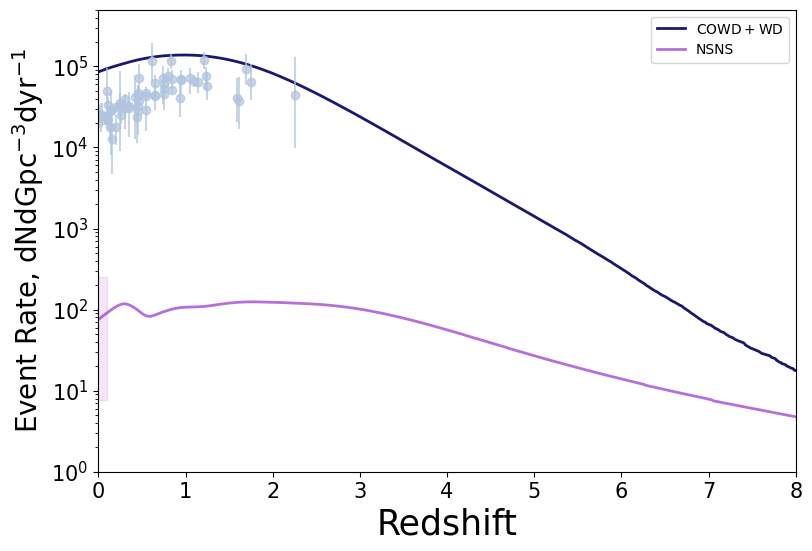

In [29]:
h_little = 0.6766

redshifts_briel = [
    0, 0.01, 0.03, (0.025+0.050)/2, 0.073, (0.05+0.15)/2, (0.075+0.125)/2, 0.11, 0.11, 0.13, 
    0.15, (0.125+0.175)/2, 0.16, (0.175+0.225)/2, 0.2, 0.25, (0.15+0.35)/2, (0.225+0.275)/2, 
    0.26, 0.3, (0.275+0.325)/2, 0.35, 0.35, 0.42, 0.44, 0.45, 0.45, (0.35+0.55)/2, 0.46, 0.47, 
    0.47, 0.55, 0.55, 0.55, 0.62, 0.65, (0.55+0.75)/2, 0.65, 0.74, 0.75, 0.75, 0.75, 0.8, 0.83, 0.85, 
    0.85, 0.94, 0.95, 0.95, 1.05, 1.1, 1.14, 1.21, 1.23, 1.25, 1.59, 1.61, 1.69, 1.75, 2.25
]

rates_briel = [
    0.77, 0.82, 0.82, 0.81, 0.71, 1.60, 0.76, 1.08, 0.72, 0.58, 0.93, 0.90, 0.41, 1.01, 0.58,
    1.05, 1.14, 1.06, 0.82, 0.99, 1.27, 0.99, 1.05, 1.34, 0.76, 0.90, 1.05, 1.52, 1.40, 1.22, 
    2.33, 0.93, 1.40, 1.52, 3.76, 1.40, 2.01, 1.43, 2.30, 1.49, 1.98, 1.69, 2.45, 3.79, 2.27, 
    1.66, 1.31, 2.22, 2.24, 2.30, 2.16, 2.06, 3.85, 2.45, 1.87, 1.31, 1.22, 2.97, 2.10, 1.43
]

# converting the rates to the correct units
rates_briel = np.array(rates_briel)
converted_rates_briel = (rates_briel*(10**5))*(h_little**3)

## uncertainties
lower_limits = [
    -0.10, -0.26, -0.32, -0.24, -0.08, -0.85, -0.13, -0.29, -0.20, -0.18, -0.67, -0.10, -0.26, -0.09, 
    -0.23, -0.76, -0.35, -0.08, -0.20, -0.44, -0.10, -0.55, -0.17, -0.93, -0.39, -0.44, -0.17, -0.38, 
    -0.50, -0.17, -0.79, -0.41, -0.17, -0.26, -1.66, -0.15, -0.52, -0.50, -1.20, -0.55, -0.61, -0.17, 
    -0.54, -0.79, -0.64, -0.15, -0.55, -0.73, -0.23, -0.82, -0.35, -0.53, -0.85, -0.82, -0.64, -0.64, 
    -0.67, -1.08, -0.87, -1.11
]

lower_limits = np.array(lower_limits)
converted_lower_limits = (lower_limits*(10**5)*(h_little**3))

upper_limits = [
    0.10, 0.26, 0.32, 0.33, 0.08, 1.46, 0.15, 0.29, 0.08, 0.20, 0.67, 0.11, 0.26, 0.09, 0.23,
    1.75, 0.38, 0.09, 0.20, 0.47, 0.11, 0.55, 0.17, 1.22, 0.67, 0.44, 0.17, 0.32, 0.50, 0.17, 
    1.08, 0.41, 0.17, 0.29, 2.57, 0.15, 0.55, 0.50, 0.96, 0.79, 0.61, 0.17, 0.67, 0.96, 0.64, 
    0.15, 0.64, 0.73, 0.23, 0.82, 0.35, 0.70, 1.05, 0.73, 0.90, 0.99, 1.14, 1.57, 1.31, 2.77
]

upper_limits = np.array(upper_limits)
converted_upper_limits = (upper_limits*(10**5)*(h_little**3))

# multiplied the lower errors by -1 so make them positive to avoid the plt.errorbar error 
y_error = [-1*(converted_lower_limits), converted_upper_limits]


#Let's now actually plot!
plt.figure(figsize=(9,6))
plt.plot(redshifts,cowd_rate,linewidth=2,linestyle='-',color='midnightblue',label=r'$\mathrm{COWD + WD}$') # all COWD

# NSNS Rate
plt.plot(redshifts,NSNS_rate,linewidth=2,color='darkorchid',alpha=0.7,label='NSNS')

## LVK BNS rate (update at z=0 - https://arxiv.org/pdf/2508.18083)
plt.fill_between([0,0.1], 
                7.6,
                250, 
                alpha=0.15, 
                color="mediumorchid")#,label=r'LVK BNS Rate $\mathrm{z=0.2}$')



## seeing if this plot matches Max Briel's paper
plt.errorbar(redshifts_briel,converted_rates_briel,yerr=y_error, fmt='o', color = 'lightsteelblue', alpha=0.7)#,label='Briel et al. 2020')


## axis
plt.xlim(0,8)
plt.ylim(10**0,5*10**5)
plt.yscale('log')
plt.ylabel(r"Event Rate, $\mathrm{dNdGpc^{-3}dyr^{-1}}$",fontsize=20)
plt.xlabel(r"Redshift",fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.title(title, pad=20)
plt.legend()


In [18]:
# we need to replot this but with Mtot > 1.4 and the 2 star SN

# let's gather the masses
mass_1_all = DCOs_NSNS['Mass(1)'][()]
mass_1 = mass_1_all[DCO_mask_NSNS]
mass_1_merged = mass_1[condition_mergers]

mass_2_all = DCOs_NSNS['Mass(2)'][()]
mass_2 = mass_2_all[DCO_mask_NSNS]
mass_2_merged = mass_2[condition_mergers]

tot_chandra_bool_merged = mass_2_merged + mass_2_merged > 1.4

In [21]:
# selecting for mtot > 1.4
rates_DCO_masked_chan = rates_DCO_masked[tot_chandra_bool_merged]

stellar_types_1_merged_chan = stellar_types_1_merged[tot_chandra_bool_merged]
stellar_types_2_merged_chan = stellar_types_2_merged[tot_chandra_bool_merged]

HeWD_bool,COWD_bool,ONeWD_bool,HeCOWD_bool,HeONeWD_bool,COHeWD_bool,COONeWD_bool,ONeHeWD_bool,ONeCOWD_bool = useful_fncs.WD_BINARY_BOOLS(stellar_types_1_merged_chan, stellar_types_2_merged_chan)
carbon_oxygen_bool_chan = np.logical_or(ONeCOWD_bool,np.logical_or(COONeWD_bool,np.logical_or(COHeWD_bool,np.logical_or(COWD_bool,HeCOWD_bool))))

cowd_rate_chan = np.sum(rates_DCO_masked_chan[carbon_oxygen_bool_chan], axis=0)

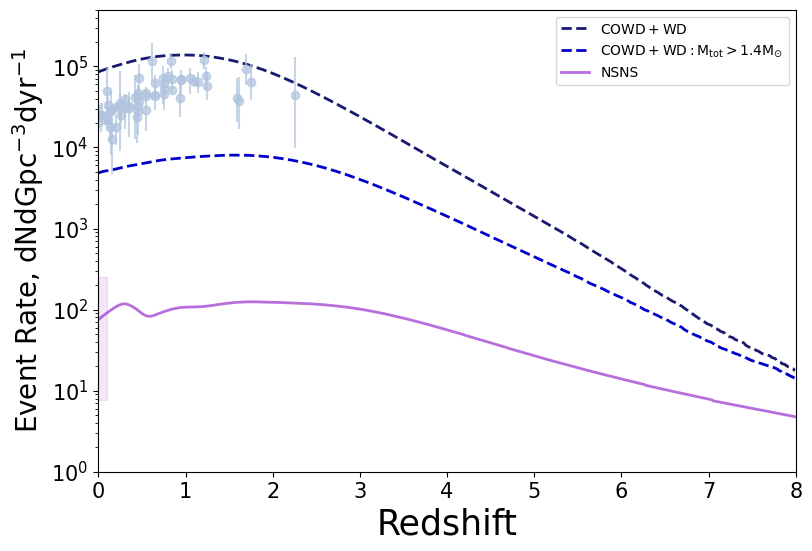

In [23]:
h_little = 0.6766

redshifts_briel = [
    0, 0.01, 0.03, (0.025+0.050)/2, 0.073, (0.05+0.15)/2, (0.075+0.125)/2, 0.11, 0.11, 0.13, 
    0.15, (0.125+0.175)/2, 0.16, (0.175+0.225)/2, 0.2, 0.25, (0.15+0.35)/2, (0.225+0.275)/2, 
    0.26, 0.3, (0.275+0.325)/2, 0.35, 0.35, 0.42, 0.44, 0.45, 0.45, (0.35+0.55)/2, 0.46, 0.47, 
    0.47, 0.55, 0.55, 0.55, 0.62, 0.65, (0.55+0.75)/2, 0.65, 0.74, 0.75, 0.75, 0.75, 0.8, 0.83, 0.85, 
    0.85, 0.94, 0.95, 0.95, 1.05, 1.1, 1.14, 1.21, 1.23, 1.25, 1.59, 1.61, 1.69, 1.75, 2.25
]

rates_briel = [
    0.77, 0.82, 0.82, 0.81, 0.71, 1.60, 0.76, 1.08, 0.72, 0.58, 0.93, 0.90, 0.41, 1.01, 0.58,
    1.05, 1.14, 1.06, 0.82, 0.99, 1.27, 0.99, 1.05, 1.34, 0.76, 0.90, 1.05, 1.52, 1.40, 1.22, 
    2.33, 0.93, 1.40, 1.52, 3.76, 1.40, 2.01, 1.43, 2.30, 1.49, 1.98, 1.69, 2.45, 3.79, 2.27, 
    1.66, 1.31, 2.22, 2.24, 2.30, 2.16, 2.06, 3.85, 2.45, 1.87, 1.31, 1.22, 2.97, 2.10, 1.43
]

# converting the rates to the correct units
rates_briel = np.array(rates_briel)
converted_rates_briel = (rates_briel*(10**5))*(h_little**3)

## uncertainties
lower_limits = [
    -0.10, -0.26, -0.32, -0.24, -0.08, -0.85, -0.13, -0.29, -0.20, -0.18, -0.67, -0.10, -0.26, -0.09, 
    -0.23, -0.76, -0.35, -0.08, -0.20, -0.44, -0.10, -0.55, -0.17, -0.93, -0.39, -0.44, -0.17, -0.38, 
    -0.50, -0.17, -0.79, -0.41, -0.17, -0.26, -1.66, -0.15, -0.52, -0.50, -1.20, -0.55, -0.61, -0.17, 
    -0.54, -0.79, -0.64, -0.15, -0.55, -0.73, -0.23, -0.82, -0.35, -0.53, -0.85, -0.82, -0.64, -0.64, 
    -0.67, -1.08, -0.87, -1.11
]

lower_limits = np.array(lower_limits)
converted_lower_limits = (lower_limits*(10**5)*(h_little**3))

upper_limits = [
    0.10, 0.26, 0.32, 0.33, 0.08, 1.46, 0.15, 0.29, 0.08, 0.20, 0.67, 0.11, 0.26, 0.09, 0.23,
    1.75, 0.38, 0.09, 0.20, 0.47, 0.11, 0.55, 0.17, 1.22, 0.67, 0.44, 0.17, 0.32, 0.50, 0.17, 
    1.08, 0.41, 0.17, 0.29, 2.57, 0.15, 0.55, 0.50, 0.96, 0.79, 0.61, 0.17, 0.67, 0.96, 0.64, 
    0.15, 0.64, 0.73, 0.23, 0.82, 0.35, 0.70, 1.05, 0.73, 0.90, 0.99, 1.14, 1.57, 1.31, 2.77
]

upper_limits = np.array(upper_limits)
converted_upper_limits = (upper_limits*(10**5)*(h_little**3))

# multiplied the lower errors by -1 so make them positive to avoid the plt.errorbar error 
y_error = [-1*(converted_lower_limits), converted_upper_limits]


#Let's now actually plot!
plt.figure(figsize=(9,6))
plt.plot(redshifts,cowd_rate,linewidth=2,linestyle='--',color='midnightblue',label=r'$\mathrm{COWD + WD}$') # all COWD
plt.plot(redshifts,cowd_rate_chan,linewidth=2,linestyle='--',color='mediumblue',label=r'$\mathrm{COWD+WD: M_{tot} > 1.4 M_{\odot}}$') # all COWD


# NSNS Rate
plt.plot(redshifts,NSNS_rate,linewidth=2,color='darkorchid',alpha=0.7,label='NSNS')

## LVK BNS rate (update at z=0 - https://arxiv.org/pdf/2508.18083)
plt.fill_between([0,0.1], 
                7.6,
                250, 
                alpha=0.15, 
                color="mediumorchid")#,label=r'LVK BNS Rate $\mathrm{z=0.2}$')



## seeing if this plot matches Max Briel's paper
plt.errorbar(redshifts_briel,converted_rates_briel,yerr=y_error, fmt='o', color = 'lightsteelblue', alpha=0.7)#,label='Briel et al. 2020')


## axis
plt.xlim(0,8)
plt.ylim(10**0,5*10**5)
plt.yscale('log')
plt.ylabel(r"Event Rate, $\mathrm{dNdGpc^{-3}dyr^{-1}}$",fontsize=20)
plt.xlabel(r"Redshift",fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.title(title, pad=20)
plt.legend()


In [25]:
# now let's get Two Star SN from Ken Shen

SN_Ia_HVS,two_star_SNIA,Champagne_Supernova = useful_fncs.check_if_SNIA(mass_1_merged, mass_2_merged)

In [26]:
# selecting for two star SN IA
rates_DCO_masked_shen = rates_DCO_masked[two_star_SNIA]

stellar_types_1_merged_shen = stellar_types_1_merged[two_star_SNIA]
stellar_types_2_merged_shen = stellar_types_2_merged[two_star_SNIA]

HeWD_bool,COWD_bool,ONeWD_bool,HeCOWD_bool,HeONeWD_bool,COHeWD_bool,COONeWD_bool,ONeHeWD_bool,ONeCOWD_bool = useful_fncs.WD_BINARY_BOOLS(stellar_types_1_merged_shen, stellar_types_2_merged_shen)
carbon_oxygen_bool_shen = np.logical_or(ONeCOWD_bool,np.logical_or(COONeWD_bool,np.logical_or(COHeWD_bool,np.logical_or(COWD_bool,HeCOWD_bool))))

cowd_rate_shen = np.sum(rates_DCO_masked_shen[carbon_oxygen_bool_shen], axis=0)

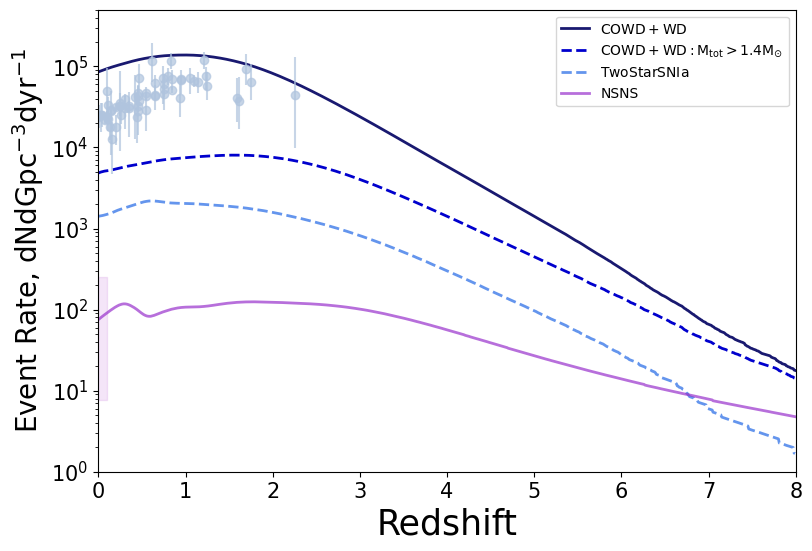

In [28]:
h_little = 0.6766

redshifts_briel = [
    0, 0.01, 0.03, (0.025+0.050)/2, 0.073, (0.05+0.15)/2, (0.075+0.125)/2, 0.11, 0.11, 0.13, 
    0.15, (0.125+0.175)/2, 0.16, (0.175+0.225)/2, 0.2, 0.25, (0.15+0.35)/2, (0.225+0.275)/2, 
    0.26, 0.3, (0.275+0.325)/2, 0.35, 0.35, 0.42, 0.44, 0.45, 0.45, (0.35+0.55)/2, 0.46, 0.47, 
    0.47, 0.55, 0.55, 0.55, 0.62, 0.65, (0.55+0.75)/2, 0.65, 0.74, 0.75, 0.75, 0.75, 0.8, 0.83, 0.85, 
    0.85, 0.94, 0.95, 0.95, 1.05, 1.1, 1.14, 1.21, 1.23, 1.25, 1.59, 1.61, 1.69, 1.75, 2.25
]

rates_briel = [
    0.77, 0.82, 0.82, 0.81, 0.71, 1.60, 0.76, 1.08, 0.72, 0.58, 0.93, 0.90, 0.41, 1.01, 0.58,
    1.05, 1.14, 1.06, 0.82, 0.99, 1.27, 0.99, 1.05, 1.34, 0.76, 0.90, 1.05, 1.52, 1.40, 1.22, 
    2.33, 0.93, 1.40, 1.52, 3.76, 1.40, 2.01, 1.43, 2.30, 1.49, 1.98, 1.69, 2.45, 3.79, 2.27, 
    1.66, 1.31, 2.22, 2.24, 2.30, 2.16, 2.06, 3.85, 2.45, 1.87, 1.31, 1.22, 2.97, 2.10, 1.43
]

# converting the rates to the correct units
rates_briel = np.array(rates_briel)
converted_rates_briel = (rates_briel*(10**5))*(h_little**3)

## uncertainties
lower_limits = [
    -0.10, -0.26, -0.32, -0.24, -0.08, -0.85, -0.13, -0.29, -0.20, -0.18, -0.67, -0.10, -0.26, -0.09, 
    -0.23, -0.76, -0.35, -0.08, -0.20, -0.44, -0.10, -0.55, -0.17, -0.93, -0.39, -0.44, -0.17, -0.38, 
    -0.50, -0.17, -0.79, -0.41, -0.17, -0.26, -1.66, -0.15, -0.52, -0.50, -1.20, -0.55, -0.61, -0.17, 
    -0.54, -0.79, -0.64, -0.15, -0.55, -0.73, -0.23, -0.82, -0.35, -0.53, -0.85, -0.82, -0.64, -0.64, 
    -0.67, -1.08, -0.87, -1.11
]

lower_limits = np.array(lower_limits)
converted_lower_limits = (lower_limits*(10**5)*(h_little**3))

upper_limits = [
    0.10, 0.26, 0.32, 0.33, 0.08, 1.46, 0.15, 0.29, 0.08, 0.20, 0.67, 0.11, 0.26, 0.09, 0.23,
    1.75, 0.38, 0.09, 0.20, 0.47, 0.11, 0.55, 0.17, 1.22, 0.67, 0.44, 0.17, 0.32, 0.50, 0.17, 
    1.08, 0.41, 0.17, 0.29, 2.57, 0.15, 0.55, 0.50, 0.96, 0.79, 0.61, 0.17, 0.67, 0.96, 0.64, 
    0.15, 0.64, 0.73, 0.23, 0.82, 0.35, 0.70, 1.05, 0.73, 0.90, 0.99, 1.14, 1.57, 1.31, 2.77
]

upper_limits = np.array(upper_limits)
converted_upper_limits = (upper_limits*(10**5)*(h_little**3))

# multiplied the lower errors by -1 so make them positive to avoid the plt.errorbar error 
y_error = [-1*(converted_lower_limits), converted_upper_limits]


#Let's now actually plot!
plt.figure(figsize=(9,6))
plt.plot(redshifts,cowd_rate,linewidth=2,linestyle='-',color='midnightblue',label=r'$\mathrm{COWD + WD}$') # all COWD
plt.plot(redshifts,cowd_rate_chan,linewidth=2,linestyle='--',color='mediumblue',label=r'$\mathrm{COWD+WD: M_{tot} > 1.4 M_{\odot}}$') # all COWD
plt.plot(redshifts,cowd_rate_shen,linewidth=2,linestyle='--',color='cornflowerblue',label=r'$\mathrm{Two Star SN Ia}$') # all COWD


# NSNS Rate
plt.plot(redshifts,NSNS_rate,linewidth=2,color='darkorchid',alpha=0.7,label='NSNS')

## LVK BNS rate (update at z=0 - https://arxiv.org/pdf/2508.18083)
plt.fill_between([0,0.1], 
                7.6,
                250, 
                alpha=0.15, 
                color="mediumorchid")#,label=r'LVK BNS Rate $\mathrm{z=0.2}$')



## seeing if this plot matches Max Briel's paper
plt.errorbar(redshifts_briel,converted_rates_briel,yerr=y_error, fmt='o', color = 'lightsteelblue', alpha=0.7)#,label='Briel et al. 2020')


## axis
plt.xlim(0,8)
plt.ylim(10**0,5*10**5)
plt.yscale('log')
plt.ylabel(r"Event Rate, $\mathrm{dNdGpc^{-3}dyr^{-1}}$",fontsize=20)
plt.xlabel(r"Redshift",fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.title(title, pad=20)
plt.legend()
